Import libraries. Pennylane libraries are mostly compatible with automatic differentiation.

In [12]:
# import envmodules
# envmodules.set_auto_fix_sys_path(1)
# envmodules.load('pytorch')

In [13]:
%matplotlib inline
import pennylane as qml
import torch

import qiskit
import qiskit.providers.aer.noise as noise
#from pennylane_cirq import ops as cirq_ops
# from pennylane_ionq import ops # not used right now, but for future
from pennylane import numpy as np # autograd compatible numpy
from pennylane.numpy import pi 
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
%precision %0.4f   
#control display precision

if True:    #for collapsing following block in Spyder or any editor
    import seaborn as sns
    
    sns.set_color_codes("deep"); sns.set_context("paper"); sns.set_style("ticks")
    STYLE_DICT = dict.fromkeys(['axes.labelsize', 'xtick.labelsize', 'ytick.labelsize', 'axes.titlesize'], 'medium')
    STYLE_DICT.update({'font.size': 18, 'figure.dpi':150, 'image.cmap': 'plasma'})
    STYLE_DICT.update(dict.fromkeys(['ytick.direction', 'xtick.direction'], 'in'))
    STYLE_DICT.update(dict.fromkeys(['xtick.major.width', 'ytick.major.width', 'axes.linewidth'], .5))
    plt.rcParams.update(STYLE_DICT)

In [14]:
N_wires = 5
num_wires = N_wires

Define a 1-qubit quantum circuit parameterized by three phase rotation angles in array phi_arr

Initial state: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

Circuit
(<Figure size 1500x600 with 1 Axes>, <Axes: >)
Test
tensor([ 0.0214+0.0518j, -0.0177+0.1341j, -0.1988+0.2591j, -0.0177+0.1341j,
        -0.1988+0.2591j, -0.7286+0.3018j, -0.1988+0.2591j, -0.0177+0.1341j],
       dtype=torch.complex128)


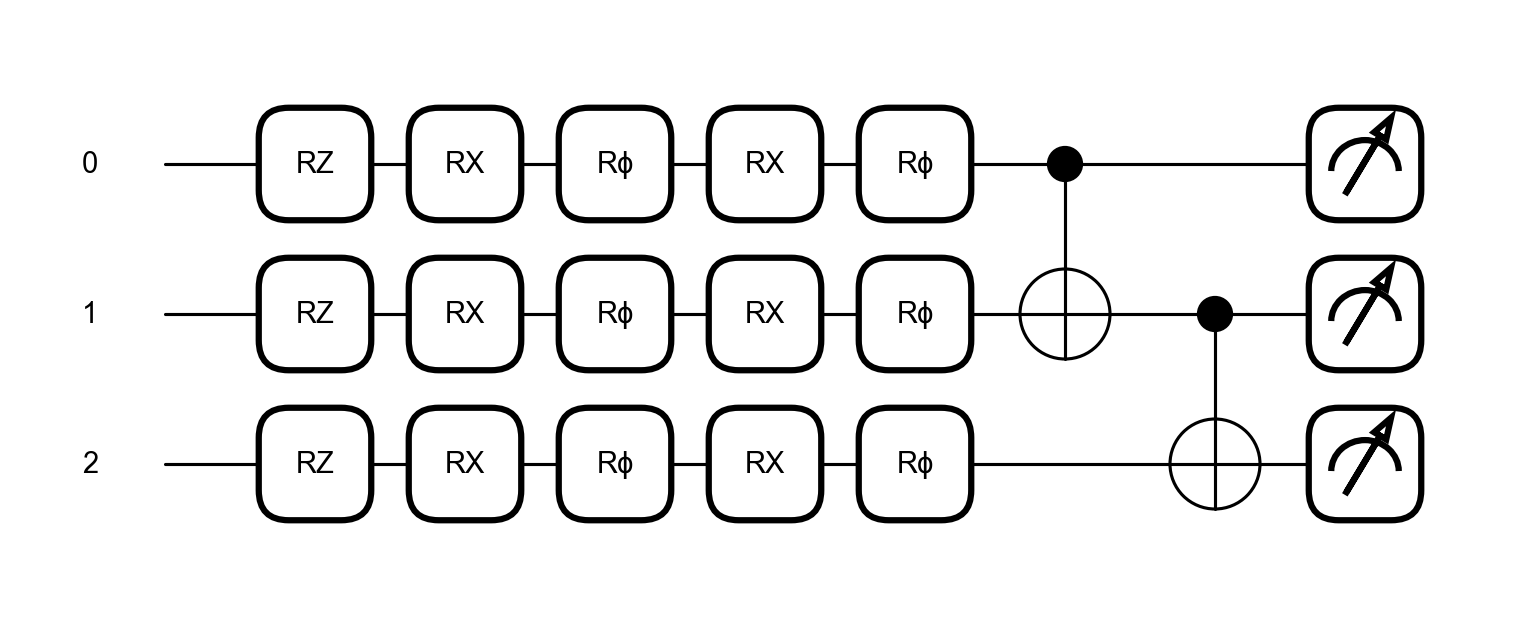

In [15]:
dev = qml.device("default.qubit", wires=3)
# print initial state in computational basis |0>, |1>
# Initialized to |0> by default
print("Initial state: " + str(dev.access_state()))

@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi_arr):
    qml.RZ(phi_arr[0], wires=0)
    qml.RX(pi/2, wires=0)
    qml.PhaseShift(phi_arr[1], wires=0)
    qml.RX(pi/2, wires=0)
    qml.PhaseShift(phi_arr[2], wires=0)
    
    qml.RZ(phi_arr[3], wires=1)
    qml.RX(pi/2, wires=1)
    qml.PhaseShift(phi_arr[4], wires=1)
    qml.RX(pi/2, wires=1)
    qml.PhaseShift(phi_arr[5], wires=1)
    
    qml.RZ(phi_arr[6], wires=2)
    qml.RX(pi/2, wires=2)
    qml.PhaseShift(phi_arr[7], wires=2)
    qml.RX(pi/2, wires=2)
    qml.PhaseShift(phi_arr[8], wires=2)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    return qml.state()


print("\nCircuit")
print(qml.draw_mpl(circuit)([pi/3, pi/4, pi/6]*3))  # show a human-readable circuit repr
print("Test")
print(circuit([pi/3, pi/4, pi/6]*3))  # test function on a random circuit

-----------
Define functions for fidelity $\langle \psi_1 | \psi_2 \rangle$, normalization ($\langle \psi | \psi\rangle=1$), parameterization 

(<Figure size 1500x600 with 1 Axes>, <Axes: >)


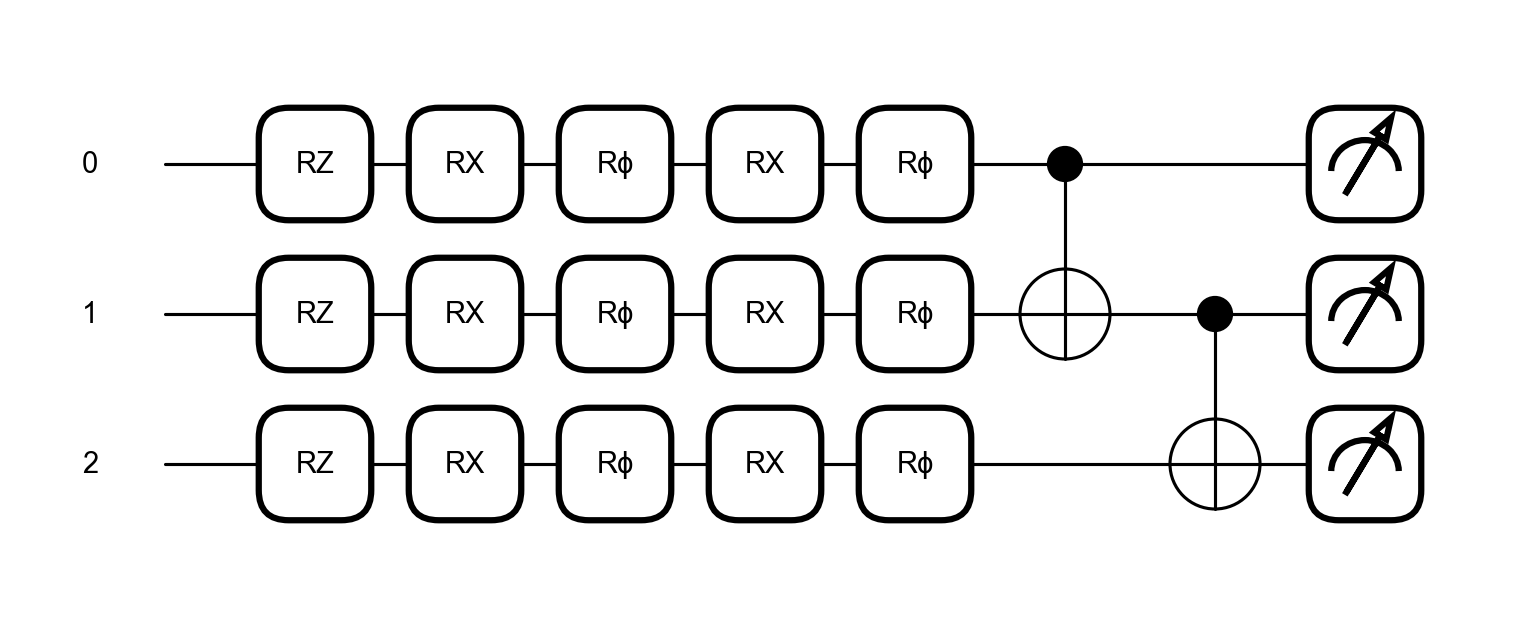

In [16]:
# Noisy quantum circuit, with uniformly distributed noise in the phases of 1-qubit gates
dev = qml.device("default.qubit", wires=num_wires)

scale_phi3 = 1
@qml.qnode(dev, interface='torch', diff_method='backprop')#, interface='torch')
def circuit_noisy(phi_arr, noise_amp=0.00):
    # rnd_gen = np.random.default_rng()
    # rnd_phases = rnd_gen.uniform(0, 1, size=len(phi_arr))*noise_amp*2*pi
    rnd_phases = torch.rand(len(phi_arr)) * noise_amp * 2*pi
    qml.RZ(phi_arr[0]+rnd_phases[0], wires=0)
    qml.RX(pi/2, wires=0)
    qml.PhaseShift(phi_arr[1]+rnd_phases[1], wires=0)
    qml.RX(pi/2, wires=0)
    qml.PhaseShift(scale_phi3*(phi_arr[2]+rnd_phases[2]), wires=0)
    
    qml.RZ(phi_arr[3]+rnd_phases[3], wires=1)
    qml.RX(pi/2, wires=1)
    qml.PhaseShift(phi_arr[4]+rnd_phases[4], wires=1)
    qml.RX(pi/2, wires=1)
    qml.PhaseShift(scale_phi3*(phi_arr[5]+rnd_phases[5]), wires=1)
    
    qml.RZ(phi_arr[6]+rnd_phases[6], wires=2)
    qml.RX(pi/2, wires=2)
    qml.PhaseShift(phi_arr[7]+rnd_phases[7], wires=2)
    qml.RX(pi/2, wires=2)
    qml.PhaseShift(scale_phi3*(phi_arr[8]+rnd_phases[8]), wires=2)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    return qml.state()

print(qml.draw_mpl(circuit_noisy)([pi/3, pi/4, pi/6]*3))

0: ──Rot(0.38,0.86,0.31)─╭●──────────╭X──Rot(0.04,0.63,0.15)─╭●───────╭X──Rot(0.99,0.09,0.30)
1: ──Rot(0.60,0.82,0.83)─╰X─╭●───────│───Rot(0.43,0.19,0.34)─│──╭●────│──╭X──────────────────
2: ──Rot(0.67,0.13,0.72)────╰X─╭●────│───Rot(0.96,0.73,0.69)─╰X─│──╭●─│──│───────────────────
3: ──Rot(0.71,0.97,0.15)───────╰X─╭●─│───Rot(0.46,0.52,0.27)────╰X─│──╰●─│───────────────────
4: ──Rot(0.93,0.22,0.78)──────────╰X─╰●──Rot(0.46,0.11,0.56)───────╰X────╰●──────────────────

───────────────────────╭●────╭X───────┤  State
───Rot(0.81,0.86,0.06)─│──╭●─│──╭X────┤  State
───Rot(0.59,0.92,0.71)─│──│──╰●─│──╭X─┤  State
───Rot(0.62,0.21,0.71)─╰X─│─────╰●─│──┤  State
───Rot(0.56,0.63,0.92)────╰X───────╰●─┤  State
(<Figure size 3150x900 with 1 Axes>, <Axes: >)
tensor([-0.3261-0.3850j,  0.0400+0.0739j, -0.0212-0.1570j, -0.0569-0.0369j,
        -0.0153+0.1112j,  0.0789-0.1272j, -0.1776-0.0557j, -0.0815-0.0515j,
         0.0877-0.0855j, -0.0799+0.0663j,  0.1301-0.1996j,  0.2317+0.0698j,
         0.0203-0.0

(<Figure size 3150x900 with 1 Axes>, <Axes: >)


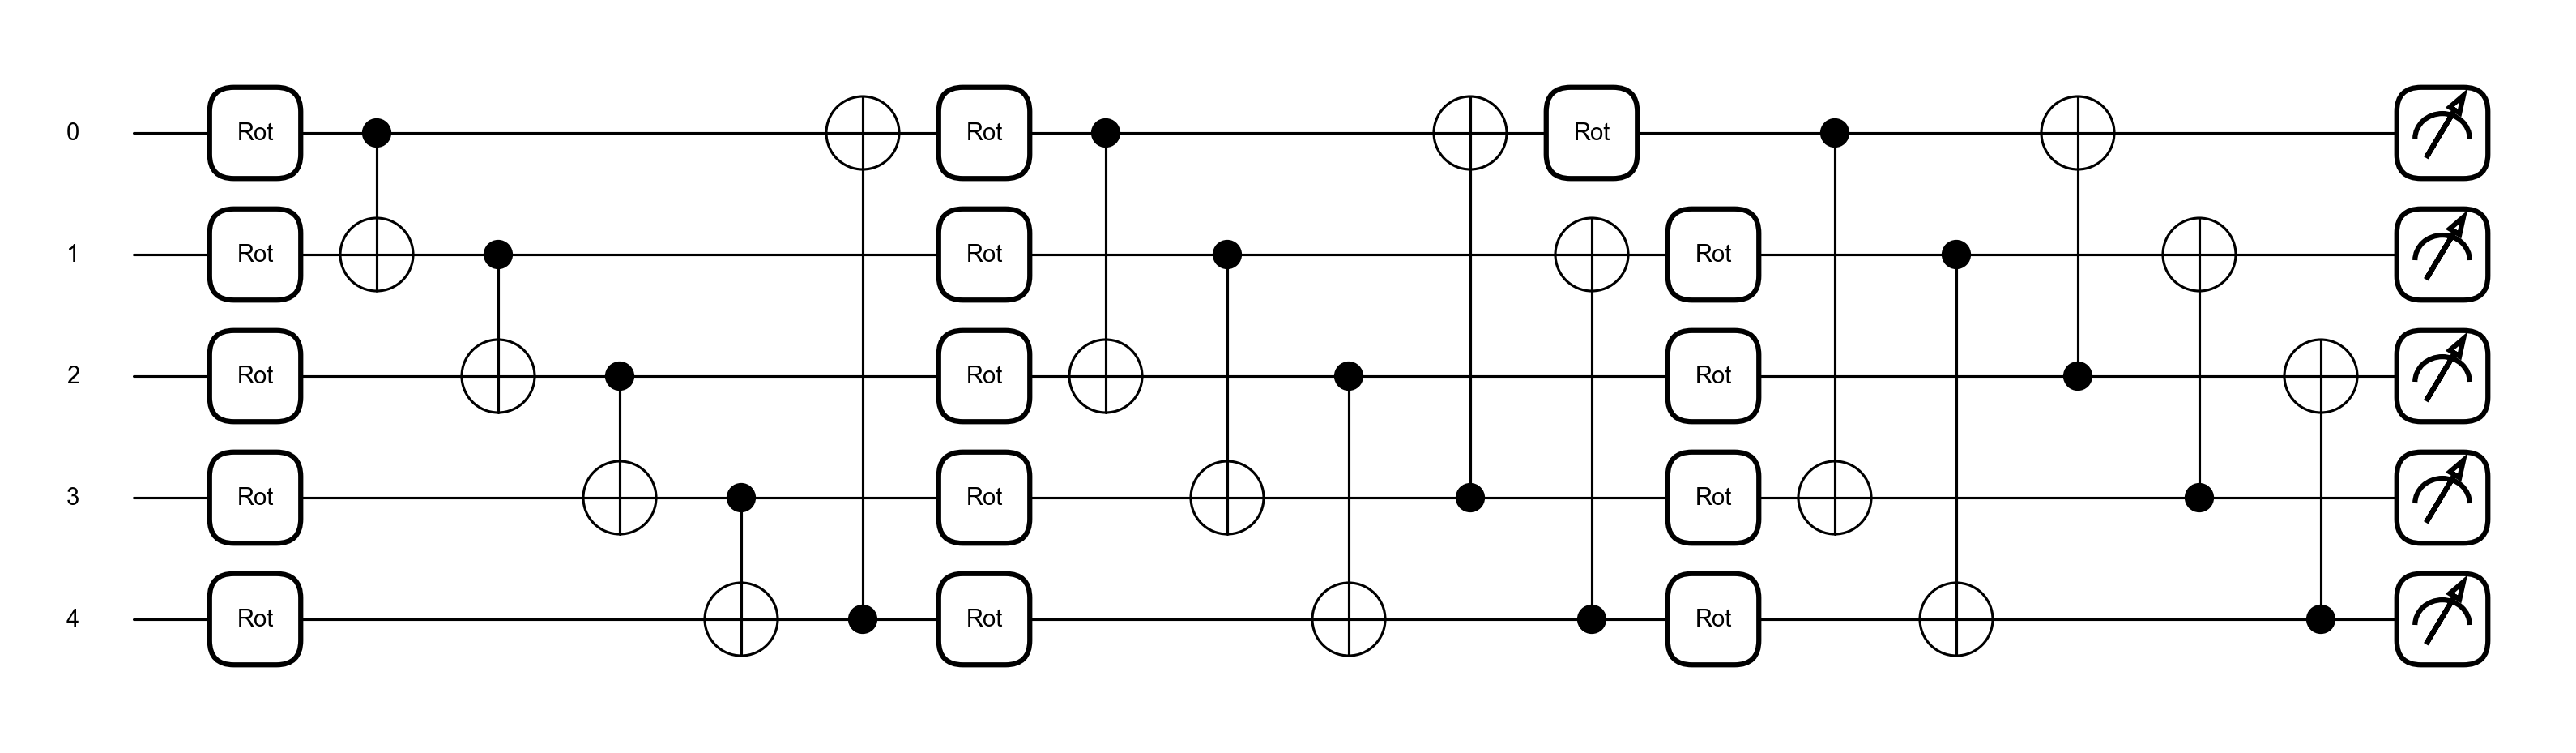

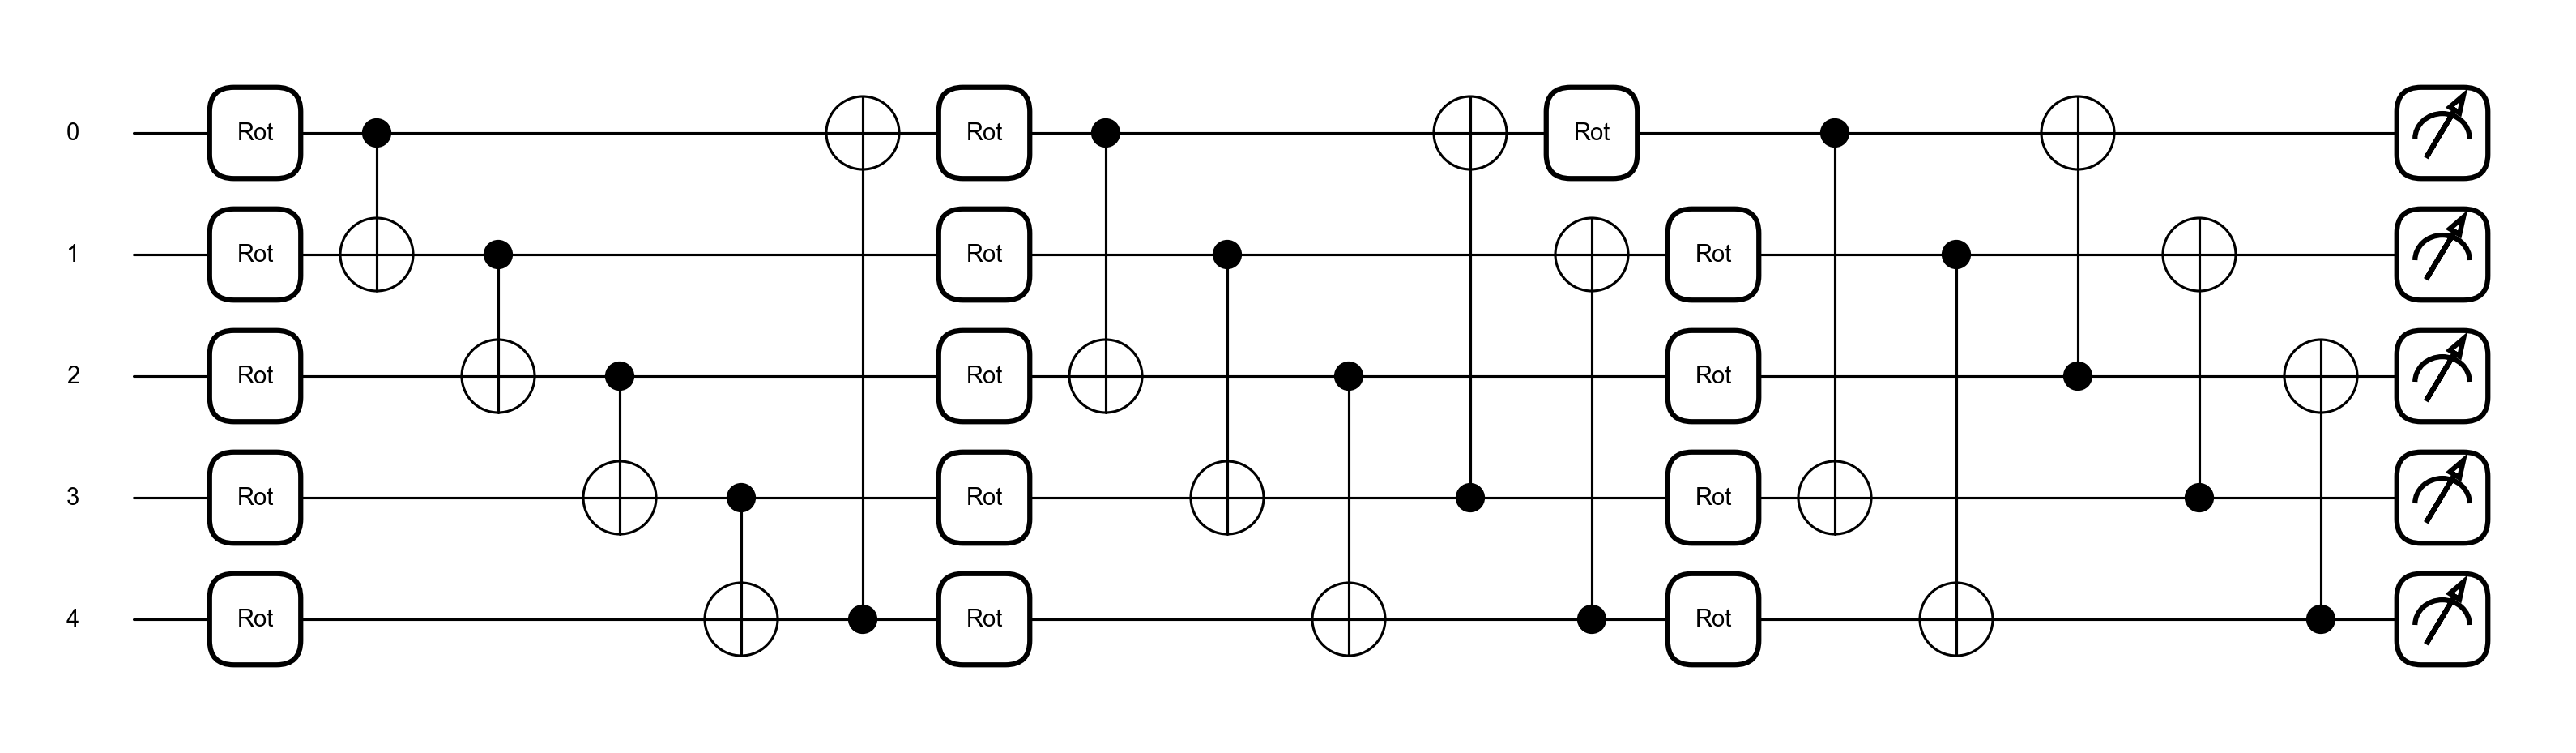

In [17]:
N_wires = num_wires
param_shape = qml.StronglyEntanglingLayers.shape(n_layers=3, n_wires=N_wires) #
weights = torch.rand(param_shape)


@qml.qnode(dev, interface='torch', diff_method="backprop")
def circuit_random_layers(parameters, noise_amp=0.00):
    # rnd_gen = np.random.default_rng()
    # rnd_phases = rnd_gen.uniform(-0.5, 0.5, size=(parameters.shape))*noise_amp*2*pi
    rnd_phases = (torch.rand(parameters.shape) - 0.50) * noise_amp*2*pi
    qml.StronglyEntanglingLayers(weights=parameters+rnd_phases, wires=range(N_wires))
    return qml.state()
print(qml.draw(circuit_random_layers, expansion_strategy='device')(weights))
print(qml.draw_mpl(circuit_random_layers, expansion_strategy='device')(weights))
print(circuit_random_layers(weights))

@qml.qnode(dev, interface='torch', diff_method="backprop")
def circuit_random_layers_no_noise(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(N_wires))
    return qml.state()
print(qml.draw(circuit_random_layers_no_noise, expansion_strategy='device')(weights))
print(qml.draw_mpl(circuit_random_layers_no_noise, expansion_strategy='device')(weights))

In [18]:
def fidelity(cur_state, target_state): # Inner product 
    # target_state = torch.Tensor(target_state)
    # cur_state = torch.Tensor(target_state)
    return torch.real(torch.dot(torch.conj(cur_state), target_state))

def norm(state): # normalize 
    # state = torch.Tensor(state)
    return state / torch.sqrt((torch.dot(torch.conj(state), state)))

def phi_parameterization(params): # restrict phase angles to -pi to pi
    return torch.clip(params, -1.5*pi, 1.5*pi) #np is okay since the params input should be a pytorch array

#state1 = circuit_random_layers(torch.tensor([-pi/4, pi/2, 0]*3))
# print(state1)
#state2 = norm(torch.tensor(np.array([1+0j, 0+0j, 0, 0, 0, 0, 0, 1]), dtype=torch.complex128))
# print(state2)
#fidelity(state1, state2)

tensor([[0.1768+0.0000j, 0.1768+0.0000j, 0.1768+0.0000j, 0.1768+0.0000j,
         0.1768+0.0000j, 0.1768+0.0000j, 0.1768+0.0000j, 0.1768+0.0000j],
        [0.1768+0.0000j, 0.1734+0.0345j, 0.1633+0.0676j, 0.1470+0.0982j,
         0.1250+0.1250j, 0.0982+0.1470j, 0.0676+0.1633j, 0.0345+0.1734j],
        [0.1768+0.0000j, 0.1633+0.0676j, 0.1250+0.1250j, 0.0676+0.1633j,
         0.1768+0.0000j, 0.1633+0.0676j, 0.1250+0.1250j, 0.0676+0.1633j],
        [0.1768+0.0000j, 0.1470+0.0982j, 0.0676+0.1633j, 0.1734+0.0345j,
         0.1250+0.1250j, 0.0345+0.1734j, 0.1633+0.0676j, 0.0982+0.1470j],
        [0.1768+0.0000j, 0.1250+0.1250j, 0.1768+0.0000j, 0.1250+0.1250j,
         0.1768+0.0000j, 0.1250+0.1250j, 0.1768+0.0000j, 0.1250+0.1250j],
        [0.1768+0.0000j, 0.0982+0.1470j, 0.1633+0.0676j, 0.0345+0.1734j,
         0.1250+0.1250j, 0.1734+0.0345j, 0.0676+0.1633j, 0.1470+0.0982j],
        [0.1768+0.0000j, 0.0676+0.1633j, 0.1250+0.1250j, 0.1633+0.0676j,
         0.1768+0.0000j, 0.0676+0.1633j, 0.12

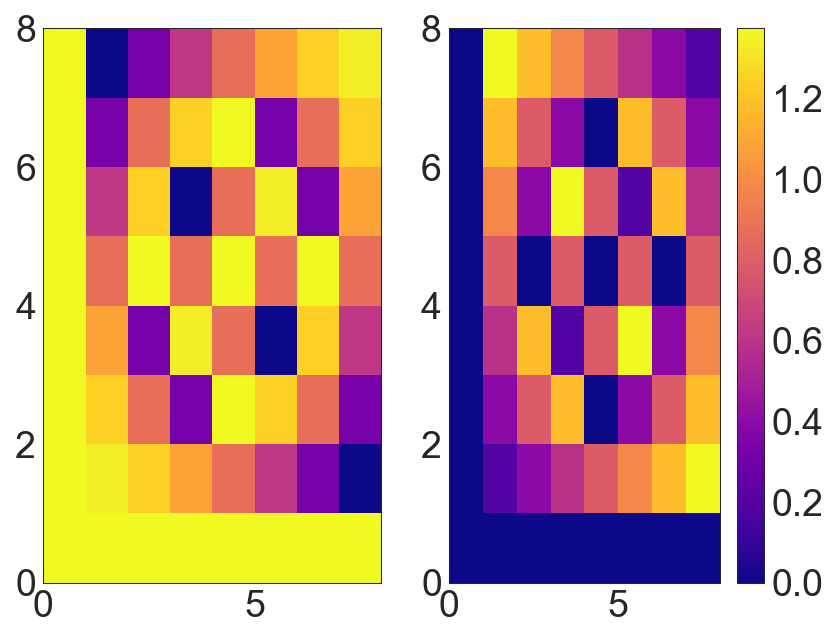

In [19]:
w = torch.exp(torch.tensor((pi*1j)/(2**(num_wires-1)), dtype=torch.complex128))
w1 = w
w2 = w*w
w3 = w*w*w
w4 = w*w*w*w
w5 = w*w*w*w*w
w6 = w*w*w*w*w*w
w7 = w*w*w*w*w*w*w
qft_3 = torch.tensor([[1,1,1,1,1,1,1,1],[1,w1,w2,w3,w4,w5,w6,w7],[1,w2,w4,w6,1,w2,w4,w6],[1,w3,w6,w,w4,w7,w2,w5],
[1,w4,1,w4,1,w4,1,w4],[1,w5,w2,w7,w4,w1,w6,w3],[1,w6,w4,w2,1,w6,w4,w2],[1,w7,w6,w5,w4,w3,w2,w1]], dtype=torch.complex128) / 2**(num_wires/2)

# qft_3 = np.eye(2**num_qubits)
plt.subplot(121); plt.pcolormesh(qft_3.real)
plt.subplot(122); plt.pcolormesh(qft_3.angle())
plt.colorbar()

print(qft_3)

Define hyperparameters for gradient descent, choose optimizer (Adam, GD, ...), 

In [20]:
from torch.autograd.functional import hessian, jacobian

In [21]:
ghz_list = [1] + [0.0]*(2**N_wires - 2) + [-1] # GHZ state
w_list = [0]*(2**N_wires); 
for ii in range(N_wires):
    w_list[2**ii] = 1; #1/torch.sqrt(N_wires) # W state
target_state = norm(torch.tensor(ghz_list, dtype=torch.complex128)) # W state
Nshots = 2 # Number of shots each with a diff initial phase angles
steps = 50 # Number of steps per shot
eta = 0.09 # learning rate
phi_len = torch.prod(torch.tensor(param_shape))
I = torch.eye(phi_len, requires_grad=False); delta = 1.50; alpha = 5*eta
# random_seeds = range(101, 25000, 33) # construct a large array of seeds > Nshots in length
random_seeds = range(14, 25000, 35) # construct a large array of seeds > Nshots in length

phi_arr_best = torch.zeros(phi_len, requires_grad=False)
costs_final = 1
cost_history_best = []
noise_amplitude = 0.000

def cost_fn_no_noise(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers_no_noise(phi_parameterization(phi_arr.reshape(param_shape))), target_state)

def cost_fn_noisy(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers(phi_parameterization(phi_arr.reshape(param_shape)), noise_amp=noise_amplitude), target_state)


for ii in range (Nshots):
    print(f"\nEpoch {ii}")
    torch.manual_seed(random_seeds[ii])
    phi_arr0 = torch.randn(phi_len, requires_grad=True)
    phi_arr = phi_arr0
    K = torch.zeros((phi_len, phi_len), requires_grad=False)
    cost_history = []

    optimizer = torch.optim.SGD([phi_arr], lr=eta*10.5)
    # optimizer = torch.optim.LBFGS([phi_arr], lr=eta/3, tolerance_change=1e-13, tolerance_grad=1e-13)
    def closure():
        print(cost_fn_noisy(phi_arr))
        optimizer.zero_grad()
        loss = cost_fn_noisy(phi_arr)
        loss.backward()
        return loss

    for jj in range(steps):
        optimizer.step(closure)
        cost = cost_fn_noisy(phi_arr)
        # -------- Following lines for IPG----------
    # for jj in range(steps):
    #     hess = hessian(cost_fn_noisy, phi_arr)
    #     K = K   -   alpha * (torch.matmul(hess, K) - I)
    #     g = jacobian(cost_fn_noisy, phi_arr)
    #     phi_arr = phi_arr - delta*torch.matmul(K, g)
    #     cost = cost_fn_noisy(phi_arr)
        #--------Above lines for IPG---------------

        # Next line is for running built-in optimizers like GD, Adam, Nesterov
        # phi_arr, cost = opt.step_and_cost(cost_fn_noisy, phi_arr, grad_fn=grad_fn)
        if (jj+1) % (steps//5) == 0 or jj==steps-1:
            print(f"Step {jj+1:3d}\t Cost_L = {cost:0.7f}")
        cost_history.append(cost.clone().detach())
    if ii == 0:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
    if costs_final > cost_history[-1]:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
SGD_best = np.copy(cost_history_best)
print(f"Best cost out of {Nshots} attempts: {np.mean(cost_history_best[steps*9//10:])}") # For noisy final costs, take a mean over last 10% of costs
print(f"Optimized phases (in $\pi$ units): {phi_arr_best/pi}")
torch.save(cost_history_best, f"costs_IPG_delta{delta}_alpha{alpha}.pt")


Epoch 0


tensor(0.9174, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7449, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6560, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6120, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5818, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5585, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5390, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5216, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5054, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4899, dtype=torch.float64, grad_fn=<RsubBackward1>)
Step  10	 Cost_L = 0.4745930
tensor(0.4746, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4593, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4438, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4283, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4127, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3975, dtype=torch.float64, grad_fn=<RsubBackwar

In [22]:
print("****")
print(cost_fn_no_noise(phi_arr))
print("****")
file_base = f"SGD_Very_bad_2epoch_delta{delta:0.2f}_alpha{alpha:0.2f}.pt"
torch.save(cost_history_best, f"costs" + file_base)
torch.save(torch.real(circuit_random_layers(phi_arr_best.reshape(param_shape))), f"stem"+file_base)

****
tensor(0.8540, dtype=torch.float64, grad_fn=<RsubBackward1>)
****


In [23]:
def unitary_circuit_random_layers_no_noise(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(N_wires))
op = qml.StronglyEntanglingLayers(weights=phi_parameterization(phi_arr_best.reshape(param_shape)), wires=range(N_wires))
matrix = qml.matrix(op)
print(type(matrix))
matrix_torch = torch.tensor(matrix, dtype=torch.complex128, requires_grad=True)

print(matrix_torch)


<class 'torch.Tensor'>
tensor([[ 0.5652-3.7898e-02j,  0.0090+1.4389e-02j,  0.0058-9.5289e-04j,
          ..., -0.0632-9.1493e-05j,  0.1149-3.0410e-02j,
          0.0657-2.2843e-02j],
        [ 0.0075+6.0696e-03j, -0.0028+9.1961e-02j, -0.1048-7.3992e-03j,
          ..., -0.2258+1.8729e-01j,  0.0115+1.3899e-02j,
         -0.2161+2.4084e-01j],
        [ 0.0085-1.9204e-02j,  0.2284+2.7811e-02j, -0.0599-4.2770e-02j,
          ...,  0.0579+1.3447e-01j,  0.0097+2.4706e-03j,
          0.0714+9.3251e-02j],
        ...,
        [-0.0060-2.3117e-02j,  0.2414+3.4962e-02j,  0.0389+4.2793e-02j,
          ...,  0.1451+3.9339e-02j, -0.0079-1.8702e-02j,
          0.1269-9.3911e-03j],
        [ 0.0108-5.6566e-04j, -0.0436+7.4746e-02j, -0.0313-4.2197e-02j,
          ..., -0.1539+2.2957e-01j,  0.0260+8.4501e-04j,
         -0.1180+2.8303e-01j],
        [-0.5455-3.5242e-02j,  0.0021-1.0455e-02j, -0.0056+2.0653e-03j,
          ..., -0.0423-8.2182e-02j, -0.0513-9.1364e-02j,
          0.0526+7.6722e-02j]], dty

C:\Users\kusha\AppData\Local\Temp\ipykernel_46704\1072321010.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix_torch = torch.tensor(matrix, dtype=torch.complex128, requires_grad=True)


Fidelity: 0.7853498137708623


(-0.6000, 0.6207)

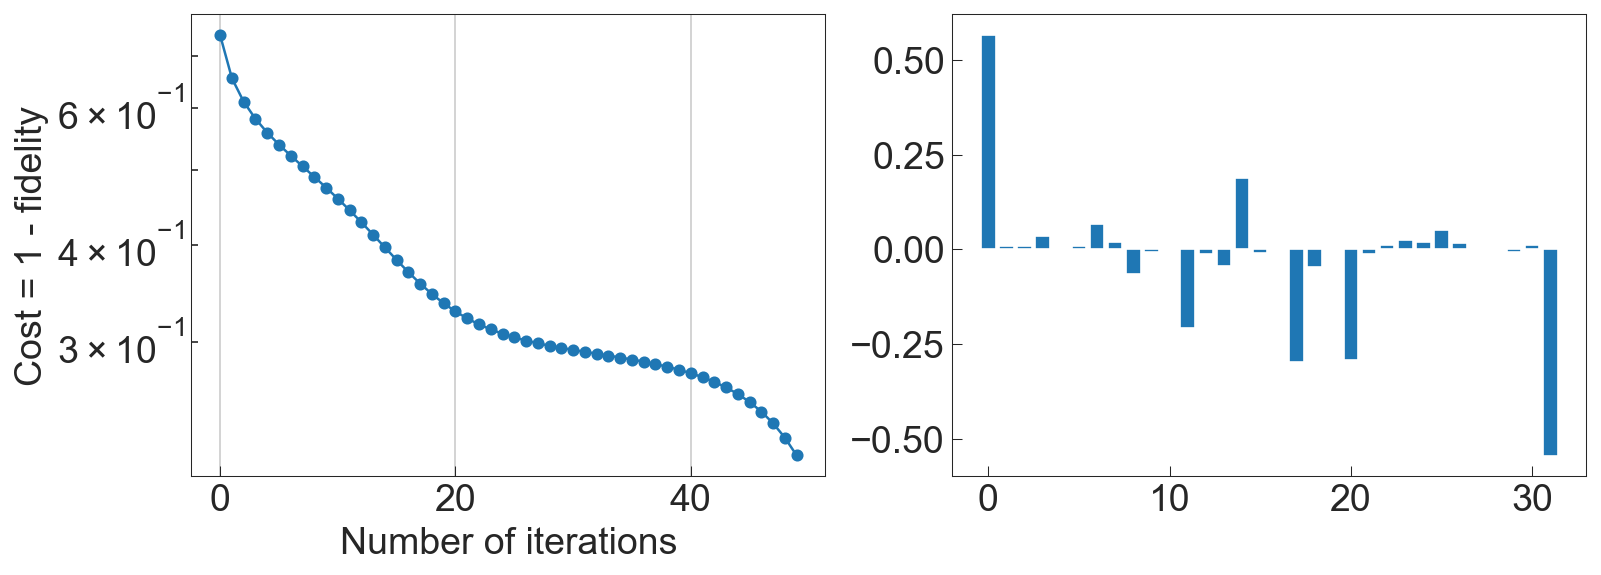

In [24]:
%matplotlib inline
plt.figure(1, figsize=(12,4))
plt.subplot(121)
plt.semilogy(np.abs(cost_history_best), 'o-')
plt.xlabel("Number of iterations")
plt.ylabel("Cost = 1 - fidelity")
plt.grid()
print(f"Fidelity: {fidelity(circuit_random_layers(phi_parameterization(phi_arr_best.reshape(param_shape)), 1*noise_amplitude), target_state)}")
plt.subplot(122)
plt.bar(range(2**N_wires), torch.real(circuit_random_layers(phi_arr_best.reshape(param_shape))), bottom=0)
plt.ylim(ymin=-0.6)


In [25]:
ghz_list = [1] + [0.0]*(2**N_wires - 2) + [-1] # GHZ state
w_list = [0]*(2**N_wires); 
for ii in range(N_wires):
    w_list[2**ii] = 1; #1/torch.sqrt(N_wires) # W state
target_state = norm(torch.tensor(ghz_list, dtype=torch.complex128)) # W state
Nshots = 2 # Number of shots each with a diff initial phase angles
steps = 50 # Number of steps per shot
eta = 0.09 # learning rate
phi_len = torch.prod(torch.tensor(param_shape))
I = torch.eye(phi_len, requires_grad=False); delta = 1.50; alpha = 5*eta
# random_seeds = range(101, 25000, 33) # construct a large array of seeds > Nshots in length
random_seeds = range(14, 25000, 35) # construct a large array of seeds > Nshots in length

phi_arr_best = torch.zeros(phi_len, requires_grad=False)
costs_final = 1
cost_history_best = []
noise_amplitude = 0.000

def cost_fn_no_noise(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers_no_noise(phi_parameterization(phi_arr.reshape(param_shape))), target_state)

def cost_fn_noisy(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers(phi_parameterization(phi_arr.reshape(param_shape)), noise_amp=noise_amplitude), target_state)


for ii in range (Nshots):
    print(f"\nEpoch {ii}")
    torch.manual_seed(random_seeds[ii])
    phi_arr0 = torch.randn(phi_len, requires_grad=True)
    phi_arr = phi_arr0
    K = torch.zeros((phi_len, phi_len), requires_grad=False)
    cost_history = []

    #optimizer = torch.optim.SGD([phi_arr], lr=eta*10.5)
    optimizer = torch.optim.LBFGS([phi_arr], lr=eta/3, tolerance_change=1e-13, tolerance_grad=1e-13)
    def closure():
        print(cost_fn_noisy(phi_arr))
        optimizer.zero_grad()
        loss = cost_fn_noisy(phi_arr)
        loss.backward()
        return loss

    for jj in range(steps):
        optimizer.step(closure)
        cost = cost_fn_noisy(phi_arr)
        # -------- Following lines for IPG----------
    # for jj in range(steps):
    #     hess = hessian(cost_fn_noisy, phi_arr)
    #     K = K   -   alpha * (torch.matmul(hess, K) - I)
    #     g = jacobian(cost_fn_noisy, phi_arr)
    #     phi_arr = phi_arr - delta*torch.matmul(K, g)
    #     cost = cost_fn_noisy(phi_arr)
        #--------Above lines for IPG---------------

        # Next line is for running built-in optimizers like GD, Adam, Nesterov
        # phi_arr, cost = opt.step_and_cost(cost_fn_noisy, phi_arr, grad_fn=grad_fn)
        if (jj+1) % (steps//5) == 0 or jj==steps-1:
            print(f"Step {jj+1:3d}\t Cost_L = {cost:0.7f}")
        cost_history.append(cost.clone().detach())
    if ii == 0:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
    if costs_final > cost_history[-1]:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
LBFGS_best = np.copy(cost_history_best)
print(f"Best cost out of {Nshots} attempts: {np.mean(cost_history_best[steps*9//10:])}") # For noisy final costs, take a mean over last 10% of costs
print(f"Optimized phases (in $\pi$ units): {phi_arr_best/pi}")
torch.save(cost_history_best, f"costs_IPG_delta{delta}_alpha{alpha}.pt")


Epoch 0
tensor(0.9174, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.9150, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.9089, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(1.1716, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(1.1224, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(1.0641, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(1.0003, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.8672, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.8581, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.8482, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.8377, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.8265, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.8147, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.8022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7892, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7758, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7620, 

Fidelity: 1.0000001000544507


(-0.6000, 0.7778)

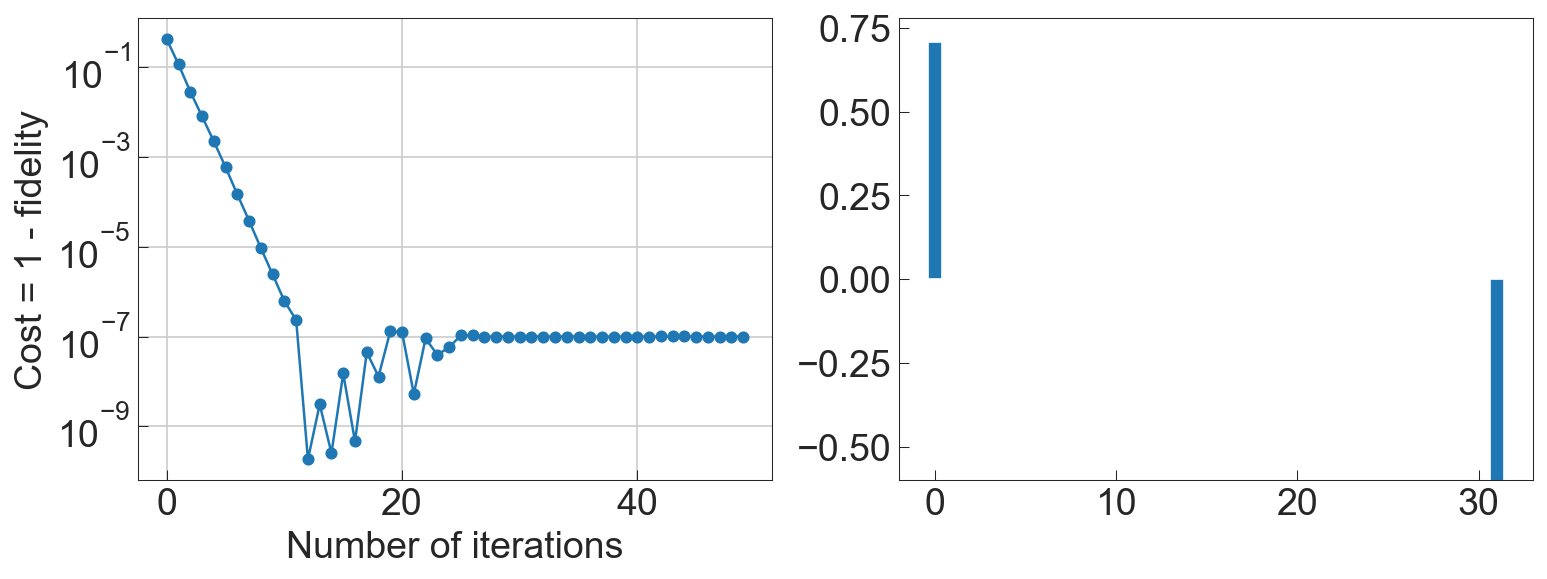

In [26]:
%matplotlib inline
plt.figure(1, figsize=(12,4))
plt.subplot(121)
plt.semilogy(np.abs(cost_history_best), 'o-')
plt.xlabel("Number of iterations")
plt.ylabel("Cost = 1 - fidelity")
plt.grid()
print(f"Fidelity: {fidelity(circuit_random_layers(phi_parameterization(phi_arr_best.reshape(param_shape)), 1*noise_amplitude), target_state)}")
plt.subplot(122)
plt.bar(range(2**N_wires), torch.real(circuit_random_layers(phi_arr_best.reshape(param_shape))), bottom=0)
plt.ylim(ymin=-0.6)

In [27]:
ghz_list = [1] + [0.0]*(2**N_wires - 2) + [-1] # GHZ state
w_list = [0]*(2**N_wires); 
for ii in range(N_wires):
    w_list[2**ii] = 1; #1/torch.sqrt(N_wires) # W state
target_state = norm(torch.tensor(ghz_list, dtype=torch.complex128)) # W state
Nshots = 2 # Number of shots each with a diff initial phase angles
steps = 50 # Number of steps per shot
eta = 0.09 # learning rate
phi_len = torch.prod(torch.tensor(param_shape))
I = torch.eye(phi_len, requires_grad=False); delta = 1.50; alpha = 5*eta
# random_seeds = range(101, 25000, 33) # construct a large array of seeds > Nshots in length
random_seeds = range(14, 25000, 35) # construct a large array of seeds > Nshots in length

phi_arr_best = torch.zeros(phi_len, requires_grad=False)
costs_final = 1
cost_history_best = []
noise_amplitude = 0.000

def cost_fn_no_noise(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers_no_noise(phi_parameterization(phi_arr.reshape(param_shape))), target_state)

def cost_fn_noisy(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers(phi_parameterization(phi_arr.reshape(param_shape)), noise_amp=noise_amplitude), target_state)


for ii in range (Nshots):
    print(f"\nEpoch {ii}")
    torch.manual_seed(random_seeds[ii])
    phi_arr0 = torch.randn(phi_len, requires_grad=True)
    phi_arr = phi_arr0
    K = torch.zeros((phi_len, phi_len), requires_grad=False)
    cost_history = []

    #optimizer = torch.optim.SGD([phi_arr], lr=eta*10.5)
    #optimizer = torch.optim.LBFGS([phi_arr], lr=eta/3, tolerance_change=1e-13, tolerance_grad=1e-13)
    optimizer = torch.optim.Adam([phi_arr], lr=eta*1.5)
    def closure():
        print(cost_fn_noisy(phi_arr))
        optimizer.zero_grad()
        loss = cost_fn_noisy(phi_arr)
        loss.backward()
        return loss

    for jj in range(steps):
        optimizer.step(closure)
        cost = cost_fn_noisy(phi_arr)
        # -------- Following lines for IPG----------
    # for jj in range(steps):
    #     hess = hessian(cost_fn_noisy, phi_arr)
    #     K = K   -   alpha * (torch.matmul(hess, K) - I)
    #     g = jacobian(cost_fn_noisy, phi_arr)
    #     phi_arr = phi_arr - delta*torch.matmul(K, g)
    #     cost = cost_fn_noisy(phi_arr)
        #--------Above lines for IPG---------------

        # Next line is for running built-in optimizers like GD, Adam, Nesterov
        # phi_arr, cost = opt.step_and_cost(cost_fn_noisy, phi_arr, grad_fn=grad_fn)
        if (jj+1) % (steps//5) == 0 or jj==steps-1:
            print(f"Step {jj+1:3d}\t Cost_L = {cost:0.7f}")
        cost_history.append(cost.clone().detach())
    if ii == 0:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
    if costs_final > cost_history[-1]:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
Adam_best = np.copy(cost_history_best)
print(f"Best cost out of {Nshots} attempts: {np.mean(cost_history_best[steps*9//10:])}") # For noisy final costs, take a mean over last 10% of costs
print(f"Optimized phases (in $\pi$ units): {phi_arr_best/pi}")
torch.save(cost_history_best, f"costs_IPG_delta{delta}_alpha{alpha}.pt")


Epoch 0
tensor(0.9174, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6962, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6593, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5889, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5523, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5493, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5253, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4888, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4623, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4363, dtype=torch.float64, grad_fn=<RsubBackward1>)
Step  10	 Cost_L = 0.4026389
tensor(0.4026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3716, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3515, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3397, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3307, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3221, dtype=torch.float64, grad_fn=<Rs

In [28]:
ghz_list = [1] + [0.0]*(2**N_wires - 2) + [-1] # GHZ state
w_list = [0]*(2**N_wires); 
for ii in range(N_wires):
    w_list[2**ii] = 1; #1/torch.sqrt(N_wires) # W state
target_state = norm(torch.tensor(ghz_list, dtype=torch.complex128)) # W state
Nshots = 2 # Number of shots each with a diff initial phase angles
steps = 50 # Number of steps per shot
eta = 0.09 # learning rate
phi_len = torch.prod(torch.tensor(param_shape))
I = torch.eye(phi_len, requires_grad=False); delta = 1.50; alpha = 5*eta
# random_seeds = range(101, 25000, 33) # construct a large array of seeds > Nshots in length
random_seeds = range(14, 25000, 35) # construct a large array of seeds > Nshots in length

phi_arr_best = torch.zeros(phi_len, requires_grad=False)
costs_final = 1
cost_history_best = []
noise_amplitude = 0.000

def cost_fn_no_noise(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers_no_noise(phi_parameterization(phi_arr.reshape(param_shape))), target_state)

def cost_fn_noisy(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers(phi_parameterization(phi_arr.reshape(param_shape)), noise_amp=noise_amplitude), target_state)


for ii in range (Nshots):
    print(f"\nEpoch {ii}")
    torch.manual_seed(random_seeds[ii])
    phi_arr0 = torch.randn(phi_len, requires_grad=True)
    phi_arr = phi_arr0
    K = torch.zeros((phi_len, phi_len), requires_grad=False)
    cost_history = []

    # optimizer = torch.optim.Adam([phi_arr], lr=eta*1.5)
    # # optimizer = torch.optim.LBFGS([phi_arr], lr=eta/3, tolerance_change=1e-13, tolerance_grad=1e-13)
    # def closure():
    #     # print("Cost Func Value: ", cost_fn_no_noise(phi_arr))
    #     optimizer.zero_grad()
    #     loss = cost_fn_no_noise(phi_arr)
    #     # print("Loss: ", loss)
    #     loss.backward()
    #     return loss

    # for jj in range(steps):
    #     optimizer.step(closure)
    #     cost = cost_fn_no_noise(phi_arr)
        # -------- Following lines for IPG----------
    for jj in range(steps):
        hess = hessian(cost_fn_no_noise, phi_arr)
        K = K   -   alpha * (torch.matmul(hess, K) - I)
        g = jacobian(cost_fn_no_noise, phi_arr)
        phi_arr = phi_arr - delta*torch.matmul(K, g)
        cost = cost_fn_no_noise(phi_arr)
        #--------Above lines for IPG---------------

        # Next line is for running built-in optimizers like GD, Adam, Nesterov
        # phi_arr, cost = opt.step_and_cost(cost_fn_noisy, phi_arr, grad_fn=grad_fn)
        if (jj+1) % (steps//5) == 0 or jj==steps-1:
            print(f"Step {jj+1:3d}\t Cost_L = {cost:0.7f}")
        cost_history.append(cost.clone().detach())
    if ii == 0:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
    if costs_final > cost_history[-1]:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
IPG_best = np.copy(cost_history_best)
print(f"Best cost out of {Nshots} attempts: {np.mean(cost_history_best[steps*9//10:])}") # For noisy final costs, take a mean over last 10% of costs
print(f"Optimized phases (in $\pi$ units): {phi_arr_best/pi}")
torch.save(cost_history_best, f"costs_IPG_delta{delta}_alpha{alpha}.pt")


Epoch 0


Step  10	 Cost_L = 0.2776559
Step  20	 Cost_L = 0.0615337
Step  30	 Cost_L = 0.0048487
Step  40	 Cost_L = 0.0000014
Step  50	 Cost_L = 0.0000002

Epoch 1
Step  10	 Cost_L = 0.0023637
Step  20	 Cost_L = 0.0000000
Step  30	 Cost_L = -0.0000000
Step  40	 Cost_L = -0.0000000
Step  50	 Cost_L = 0.0000001
Best cost out of 2 attempts: 2.386754416328074e-08
Optimized phases (in $\pi$ units): tensor([ 8.6619e-02, -5.0000e-01,  5.0000e-01,  3.9318e-02,  5.0000e-01,
        -5.0000e-01,  1.6431e-01, -5.5806e-11, -1.2192e-01, -2.2799e-01,
        -1.2395e-10,  7.1669e-01,  2.6147e-02,  2.5661e-01, -5.6376e-12,
         2.5259e-09,  5.0000e-01,  9.3426e-02, -2.9608e-01, -8.5082e-11,
        -1.5948e-01, -1.9588e-01, -4.5432e-11, -1.1904e-01,  2.7016e-01,
        -1.2716e-10,  1.3480e-01, -4.5800e-08,  2.5661e-01,  3.1980e-01,
        -1.7191e-01,  1.3885e-10, -6.7273e-01,  1.4809e-01, -4.3250e-11,
        -2.3326e-01, -1.6524e-01, -3.2277e-12,  9.5235e-03,  4.4720e-01,
        -6.7615e-11, -3.8949e

Fidelity: 0.9999998800899428


(-0.6000, 0.7778)

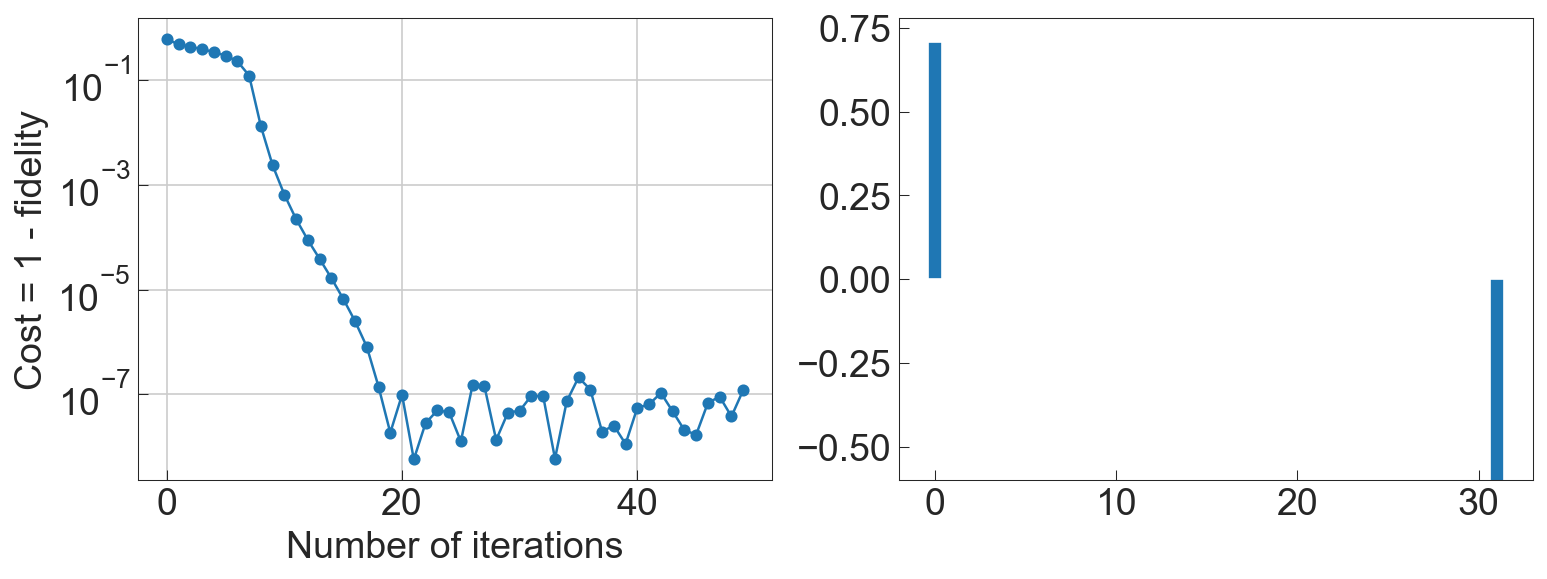

In [29]:
%matplotlib inline
plt.figure(1, figsize=(12,4))
plt.subplot(121)
plt.semilogy(np.abs(cost_history_best), 'o-')
plt.xlabel("Number of iterations")
plt.ylabel("Cost = 1 - fidelity")
plt.grid()
print(f"Fidelity: {fidelity(circuit_random_layers(phi_parameterization(phi_arr_best.reshape(param_shape)), 1*noise_amplitude), target_state)}")
plt.subplot(122)
plt.bar(range(2**N_wires), torch.real(circuit_random_layers(phi_arr_best.reshape(param_shape))), bottom=0)
plt.ylim(ymin=-0.6)

<Axes: title={'center': 'Best Cost History'}, xlabel='Number of iterations', ylabel='Cost'>

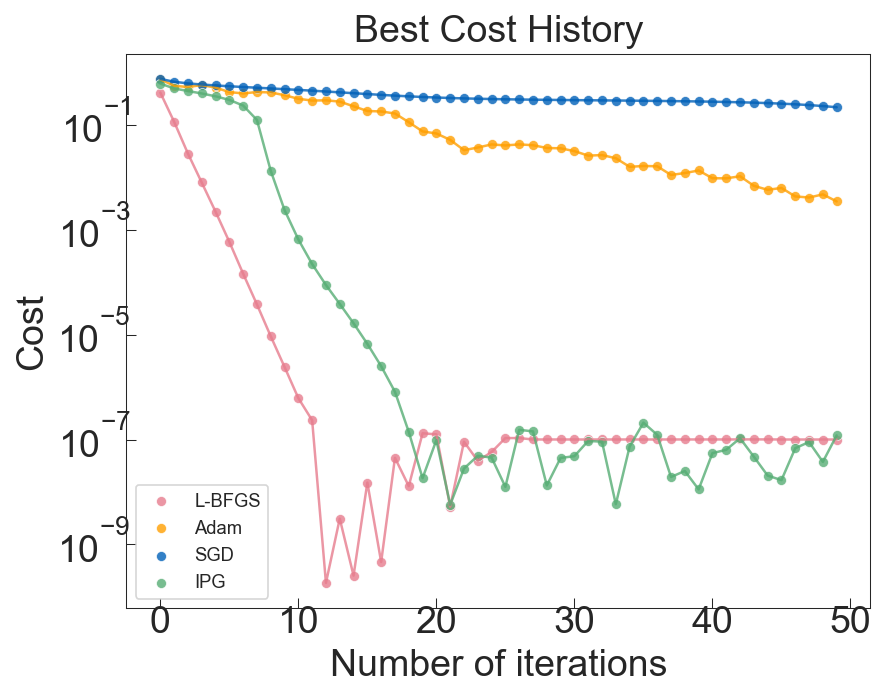

In [30]:
%matplotlib inline
limit=50
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.title("Best Cost History")
plt.yscale('log')
plt.yticks(va='center')
plt.xticks(va='center')
plt.tick_params(axis='y', pad=-2)
plt.tick_params(axis='x', pad=7)
sns.set_style("whitegrid")
sns.lineplot(x=[i for i in range(0, limit)], y=np.abs(LBFGS_best), color="#e77c8d", alpha=0.8)
sns.lineplot(x=[i for i in range(0, limit)], y=np.abs(Adam_best), color="#ff9f00", alpha=0.8)
sns.lineplot(x=[i for i in range(0, limit)], y=np.abs(SGD_best), color="#0060b8", alpha=0.8)
sns.lineplot(x=[i for i in range(0, limit)], y=np.abs(IPG_best), color="#56ad74", alpha=0.8)
sns.scatterplot(x=[i for i in range(0, limit)], y=np.abs(LBFGS_best), label="L-BFGS", color="#e77c8d", alpha=0.8)
sns.scatterplot(x=[i for i in range(0, limit)], y=np.abs(Adam_best), label="Adam", color="#ff9f00", alpha=0.8)
sns.scatterplot(x=[i for i in range(0, limit)], y=np.abs(SGD_best), label="SGD", color="#0060b8", alpha=0.8)
sns.scatterplot(x=[i for i in range(0, limit)], y=np.abs(IPG_best), label="IPG", color="#56ad74", alpha=0.8)

[4.08875642e-01 1.13584162e-01 2.81967845e-02 7.90396770e-03
 2.20357814e-03 5.85294657e-04 1.44851867e-04 3.75343233e-05
 9.27873206e-06 2.41636229e-06 6.15214122e-07 2.32704954e-07
 1.85434668e-10 3.10706638e-09 2.55039101e-10 1.51133954e-08
 4.63369676e-10 4.48042006e-08 1.29281414e-08 1.31638695e-07
 1.25385436e-07 5.26782107e-09 9.07031124e-08 3.92347420e-08
 5.76725974e-08 1.06616475e-07 1.06616440e-07 1.00177305e-07
 1.00177280e-07 1.00177255e-07 1.00177230e-07 1.00177206e-07
 1.00177182e-07 1.00177159e-07 1.00177136e-07 1.00177113e-07
 1.00177091e-07 1.00177069e-07 1.00279961e-07 1.00279941e-07
 1.00279920e-07 1.00279899e-07 1.00434244e-07 1.00537141e-07
 1.00537123e-07 1.00054521e-07 1.00054503e-07 1.00054486e-07
 1.00054468e-07 1.00054451e-07]


<Axes: >

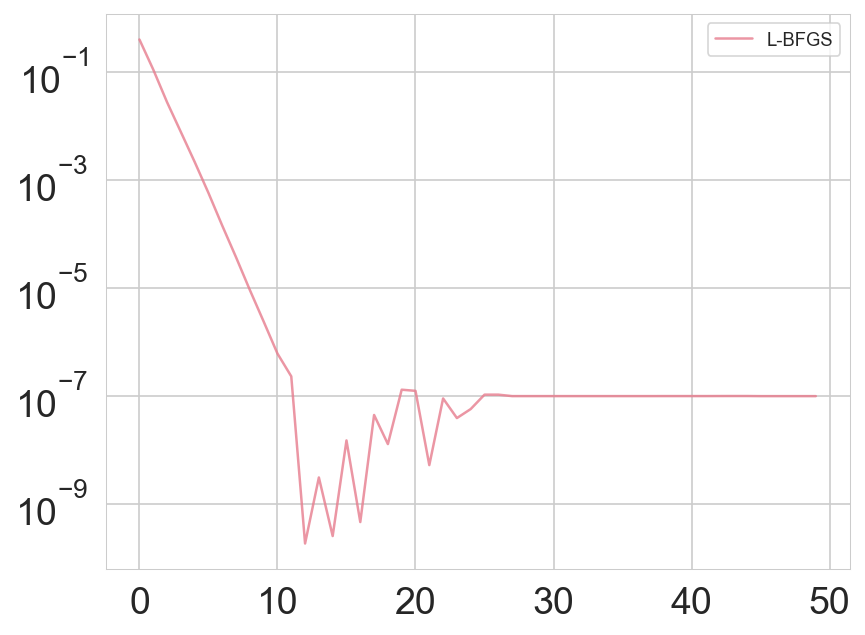

In [31]:
print(np.abs(LBFGS_best.tolist()))
plt.yscale('log')
#sns.lineplot(x=[i for i in range(0, limit)], y=IPG_best, label="IPG", color="#56ad74", alpha=0.8)
sns.lineplot(x=[i for i in range(0, limit)], y=np.abs(LBFGS_best.tolist()), label="L-BFGS", color="#e77c8d", alpha=0.8)
#sns.lineplot(x=[i for i in range(0, limit)], y=Adam_best, label="Adam", color="#ff9f00", alpha=0.8)

In [32]:
IPG_best

tensor([ 6.04995119e-01,  4.89785827e-01,  4.37289801e-01,
         3.92969133e-01,  3.47119495e-01,  2.96049712e-01,
         2.31295506e-01,  1.23145609e-01,  1.32262515e-02,
         2.36370034e-03,  6.49897475e-04,  2.20558387e-04,
         8.80415652e-05,  3.83616771e-05,  1.64179876e-05,
         6.64760678e-06,  2.49858826e-06,  8.11433105e-07,
         1.39957323e-07,  1.83745650e-08,  9.73586447e-08,
         5.67878145e-09, -2.79828527e-08, -4.90169505e-08,
         4.52429696e-08, -1.25348838e-08,  1.53017665e-07,
        -1.42949742e-07, -1.33377460e-08, -4.45861401e-08,
        -4.81533160e-08, -9.41881688e-08, -9.08277431e-08,
        -5.86299764e-09, -7.31852317e-08, -2.09335751e-07,
        -1.22829169e-07,  1.93121836e-08, -2.51513514e-08,
        -1.12185425e-08,  5.50314060e-08,  6.37493676e-08,
        -1.05875167e-07,  4.70696138e-08,  2.05674856e-08,
        -1.68272976e-08,  6.83721475e-08, -8.96283614e-08,
         3.75111751e-08,  1.19910057e-07], requires_grad